In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

In [2]:
batchSize = 1024
path_data = '/work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2.parquet'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

#model_dir= "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd/preTraining_spanet_huber_mmd_v7_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:4_LayersEnc:6_nheadDec:4_LayersDec:4/"
# model_dir = "/work/dvalsecc/MEM/models_archive/flow_pretraining_huber_mmd/preTraining_spanet_huber_mmd_v10c_hiddenFeatures:128_dimFeedForward:1024_nheadEnc:8_LayersEnc:5_nheadDec:8_LayersDec:5"

# #model_dir= '/work/dvalsecc/MEM/models_archive/flow_pretraining_spanet/preTraining_spanet_v2_noProv:True_cartesian:False_HuberLoss:True_latent_space:True_hiddenFeatures:64_dimFeedForward:1024_nheadEnc:4_LayersEnc:6_nheadDec:4_LayersDec:4/'
# path_unscaled = model_dir + '/unscaledRegressedPartonsTensor.pt'
# #path_to_conf = model_dir + '/config_spanet_v2.yaml'
# path_to_conf = model_dir + '/config_spanet_huber_mmd_v10c.yaml'
# #model_path = model_dir + '/model_spanet_v2.pt'
# model_path = model_dir + '/model_spanet_huber_mmd_v10c.pt'
# with open(path_to_conf) as f:
#         conf = OmegaConf.load(path_to_conf)

# log_mean = torch.tensor(conf.scaling_params.log_mean, device=device)
# log_std = torch.tensor(conf.scaling_params.log_std, device=device)

In [3]:
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=['scaledLogRecoParticles', 'mask_lepton', 
                                            'mask_jets','mask_met',
                                            'mask_boost', 'data_boost'],
                        parton_list=["logScaled_data_higgs_t_tbar_ISR"], build=False)

dataCorrect = data.parton_data.data_higgs_t_tbar_ISR_cartesian

higgsCorrect = vector.array(
    {
        "E": dataCorrect[:,0,0].detach().numpy(),
        "px": dataCorrect[:,0,1].detach().numpy(),
        "py": dataCorrect[:,0,2].detach().numpy(),
        "pz": dataCorrect[:,0,3].detach().numpy(),
    }
)

thadCorrect = vector.array(
    {
        "E": dataCorrect[:,1,0].detach().numpy(),
        "px": dataCorrect[:,1,1].detach().numpy(),
        "py": dataCorrect[:,1,2].detach().numpy(),
        "pz": dataCorrect[:,1,3].detach().numpy(),
    }
)

tlepCorrect = vector.array(
    {
        "E": dataCorrect[:,2,0].detach().numpy(),
        "px": dataCorrect[:,2,1].detach().numpy(),
        "py": dataCorrect[:,2,2].detach().numpy(),
        "pz": dataCorrect[:,2,3].detach().numpy(),
    }
)

glISRCorrect = vector.array(
    {
        "E": dataCorrect[:,3,0].detach().numpy(),
        "px": dataCorrect[:,3,1].detach().numpy(),
        "py": dataCorrect[:,3,2].detach().numpy(),
        "pz": dataCorrect[:,3,3].detach().numpy(),
    }
)

higgsCM = ak.with_name(higgsCorrect, name="Momentum4D")
thadCM = ak.with_name(thadCorrect, name="Momentum4D")
tlepCM = ak.with_name(tlepCorrect, name="Momentum4D")
glISRCM = ak.with_name(glISRCorrect, name="Momentum4D")

boost_reco = data.reco_data.data_boost.squeeze(1)
boost_truth = data.parton_data.data_boost.squeeze(1)

boost_reco_p4 = ak.Array(
                {
                    "x": boost_reco[:,1],
                    "y": boost_reco[:,2],
                    "z": boost_reco[:,3],
                    "t": boost_reco[:,0],
                }
            )

boost_reco_p4 = ak.with_name(boost_reco_p4, name="Momentum4D")

boost_truth_p4 = ak.Array(
                {
                    "x": boost_truth[:,1],
                    "y": boost_truth[:,2],
                    "z": boost_truth[:,3],
                    "t": boost_truth[:,0],
                }
            )

boost_truth_p4 = ak.with_name(boost_truth_p4, name="Momentum4D")

Get data boosted in CM

RecoLevel
Badsedir:  /work/dvalsecc/MEM/datasets/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part2
Reading reco_level Files
Load scaledLogRecoParticles

PartonLevel
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR



In [4]:
data_raw = ak.from_parquet(path_data)

In [5]:
higgs_lab = ak.with_name(data_raw["higgs"], name="Momentum4D")

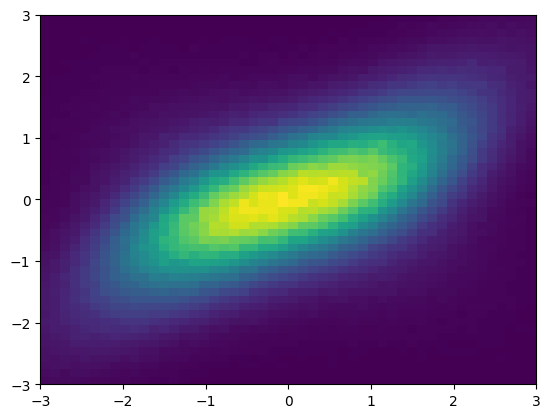

In [6]:
plt.hist2d(higgs_lab[:,0].eta.to_numpy(),  higgsCM.eta.to_numpy(),
          bins=50, range=((-3,3), (-3,3)));

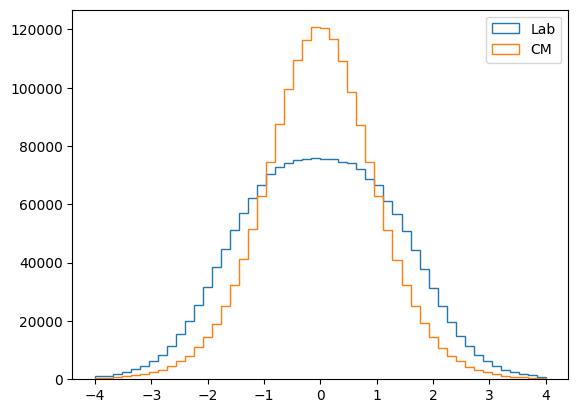

In [19]:
plt.hist(higgs_lab[:,0].eta.to_numpy(),bins=50, range=(-4,4), label="Lab", histtype="step")
plt.hist(higgsCM.eta.to_numpy(),bins=50, range=(-4,4), label="CM", histtype="step")
plt.legend()

Text(0, 0.5, 'Boost reco')

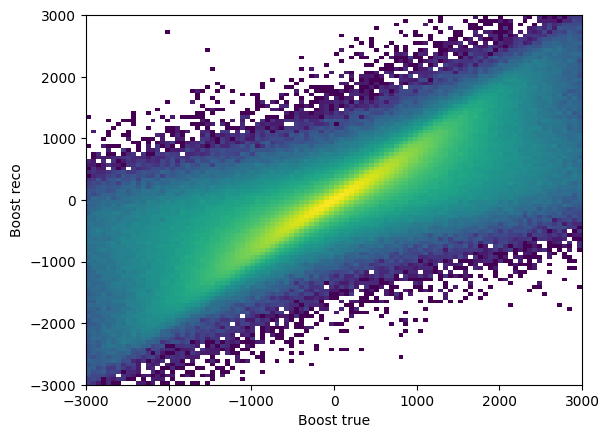

In [33]:
plt.hist2d( boost_truth[:, 3].numpy(), 
            boost_reco[:,3].numpy(), 
          bins=100, range=((-3000, 3000),(-3000, 3000)), norm=LogNorm());
plt.xlabel("Boost true")
plt.ylabel("Boost reco")

Text(0, 0.5, 'Boost reco')

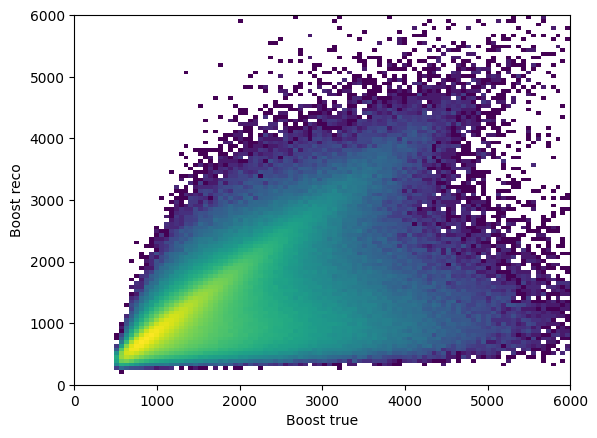

In [290]:
plt.hist2d( boost_truth[:, 0].numpy(), 
            boost_reco[:,0].numpy(), 
          bins=100, range=((0, 6000),(0, 6000)), norm=LogNorm());
plt.xlabel("Boost true")
plt.ylabel("Boost reco")

Text(0.5, 0, 'Boost reco')

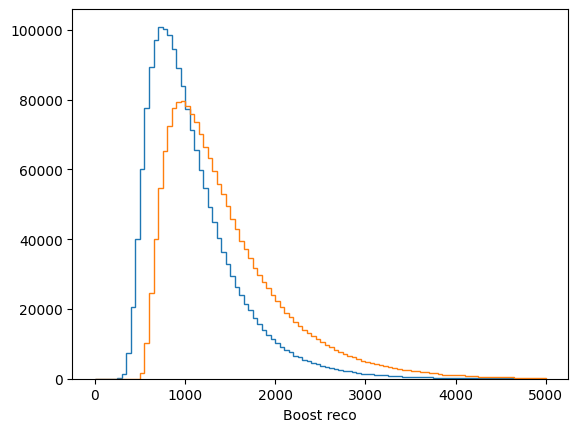

In [294]:
plt.hist( boost_reco[:,0].numpy(),  bins=100, range=(0,5000), histtype="step", label="reco");
plt.hist( boost_truth[:,0].numpy(),  bins=100, range=(0,5000), histtype="step", label="truth");
plt.xlabel("Boost reco")

In [7]:
from memflow.unfolding_flow import mmd_loss

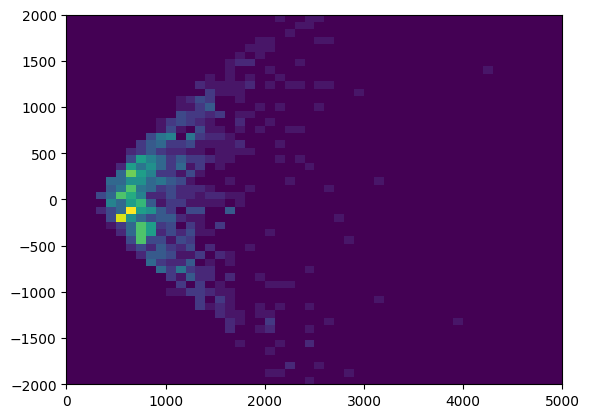

In [8]:
plt.hist2d(boost_reco[:1024, 0].numpy(), boost_reco[:1024, -1].numpy(), bins=50, range=((0, 5000), (-2000,2000)) );

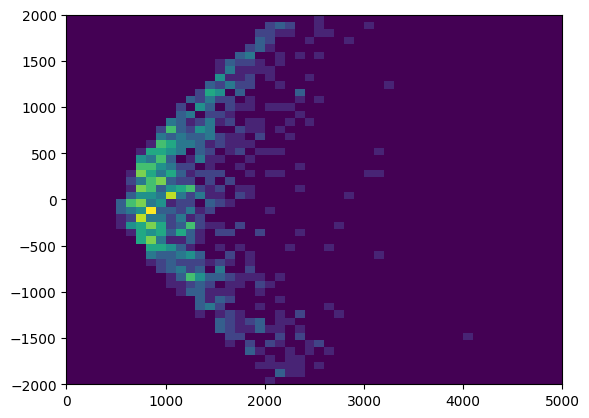

In [9]:
plt.hist2d(boost_truth[:1024, 0].numpy(), boost_truth[:1024, -1].numpy(), bins=50, range=((0, 5000), (-2000,2000)) );

In [34]:
breco = boost_reco[:2048, [0,-1]]
btrue = boost_truth[:2048,[0,-1]]

In [43]:
btrue_log = torch.sign(btrue)*torch.log(1+btrue.abs())
btrue_log_scaled = (btrue_log - btrue_log.mean(0))/btrue_log.std(0)

breco_log = torch.sign(breco)*torch.log(1+breco.abs())
breco_log_scaled = (breco_log - btrue_log.mean(0))/btrue_log.std(0)



(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  36., 102., 169.,
        194., 158., 120.,  90.,  43.,  34.,  20.,  11.,   8.,   5.,   4.,
          0.,   1.,   0.,   5.,   0.,   1.,   2.,   4.,   7.,  18.,  23.,
         40.,  86., 116., 148., 222., 208., 131.,  36.,   5.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-2.  , -1.92, -1.84, -1.76, -1.68, -1.6 , -1.52, -1.44, -1.36,
        -1.28, -1.2 , -1.12, -1.04, -0.96, -0.88, -0.8 , -0.72, -0.64,
        -0.56, -0.48, -0.4 , -0.32, -0.24, -0.16, -0.08,  0.  ,  0.08,
         0.16,  0.24,  0.32,  0.4 ,  0.48,  0.56,  0.64,  0.72,  0.8 ,
         0.88,  0.96,  1.04,  1.12,  1.2 ,  1.28,  1.36,  1.44,  1.52,
         1.6 ,  1.68,  1.76,  1.84,  1.92,  2.  ]),
 <BarContainer object of 50 artists>)

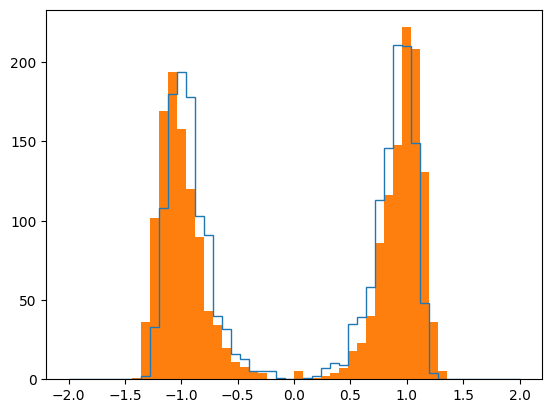

In [44]:
plt.hist(breco_log_scaled[:,1],bins=50, range=(-2,2), histtype="step")
plt.hist(btrue_log_scaled[:,1],bins=50, range=(-2,2))

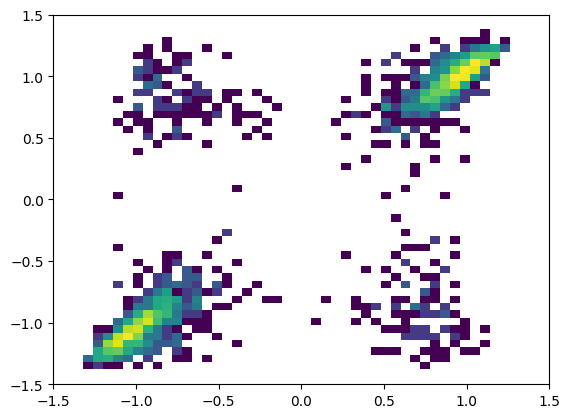

In [52]:
plt.hist2d(breco_log_scaled[:,1].numpy(),
           btrue_log_scaled[:,1].numpy(),
           bins=50, range=((-1.5,1.5),(-1.5,1.5)),
          norm=LogNorm());

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  6., 13., 20., 30., 29.,
        44., 79., 76., 70., 95., 88., 88., 98., 87., 78., 87., 89., 96.,
        87., 87., 76., 72., 48., 80., 47., 55., 54., 44., 45., 29., 24.,
        27., 17., 15., 14., 11., 11.,  5.,  7.,  6.,  3.,  4.]),
 array([-3.  , -2.88, -2.76, -2.64, -2.52, -2.4 , -2.28, -2.16, -2.04,
        -1.92, -1.8 , -1.68, -1.56, -1.44, -1.32, -1.2 , -1.08, -0.96,
        -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24, -0.12,  0.  ,  0.12,
         0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,  1.08,  1.2 ,
         1.32,  1.44,  1.56,  1.68,  1.8 ,  1.92,  2.04,  2.16,  2.28,
         2.4 ,  2.52,  2.64,  2.76,  2.88,  3.  ]),
 <BarContainer object of 50 artists>)

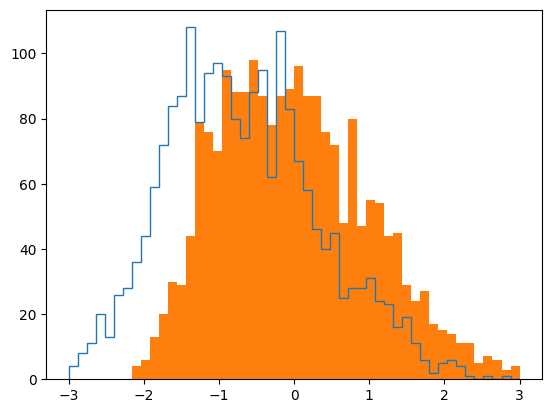

In [49]:
plt.hist(breco_log_scaled[:,0],bins=50, range=(-3,3), histtype="step")
plt.hist(btrue_log_scaled[:,0],bins=50, range=(-3,3))

In [47]:
mmd_loss.MMD(btrue_log_scaled[:2048], breco_log_scaled[:2048], kernel="rbf", device="cpu")

tensor(0.0818)

In [15]:
from  torch.nn import HuberLoss as huber

In [19]:
huber(delta=2)(boost_reco[:2048, [0,-1]],boost_truth[:2048, [0,-1]])

tensor(764.3375)

Text(0.5, 0, 'Boost reco')

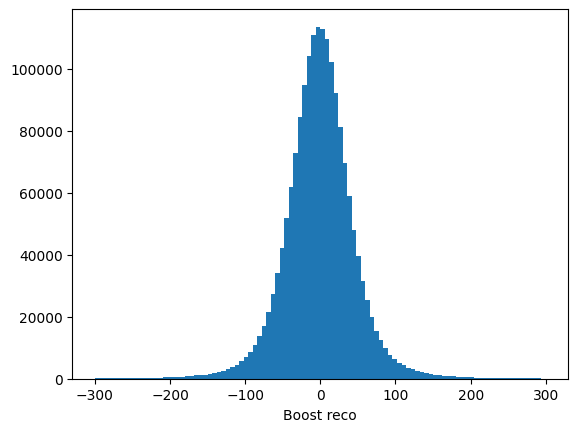

In [292]:
plt.hist( boost_reco[:,1].numpy(), 
          bins=100, range=(-300, 300));
plt.xlabel("Boost reco")

Text(0.5, 0, 'Boost pz')

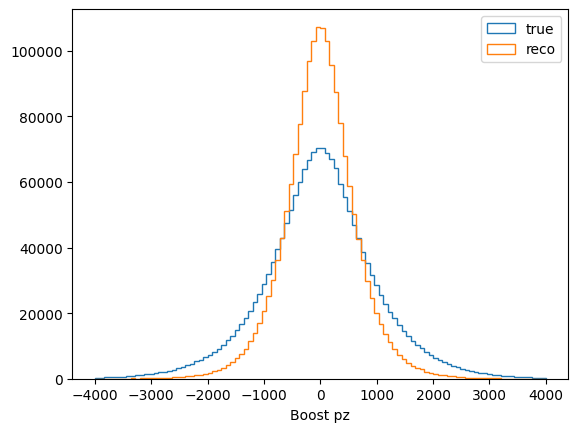

In [34]:
plt.hist(boost_truth[:,3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="true");
plt.hist(boost_reco[:,3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="reco");
plt.legend()
plt.xlabel("Boost pz")

Text(0.5, 0, 'Boost pz')

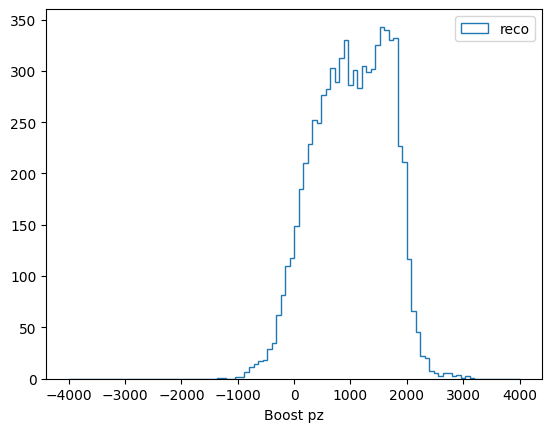

In [255]:
mask = (boost_truth[:,3]>2000 )&(boost_truth[:,3]<2100)
plt.hist(boost_reco[mask,3].numpy(), bins=100, histtype="step", range=(-4000,4000), label="reco");
plt.legend()
plt.xlabel("Boost pz")

# Check the Higgs

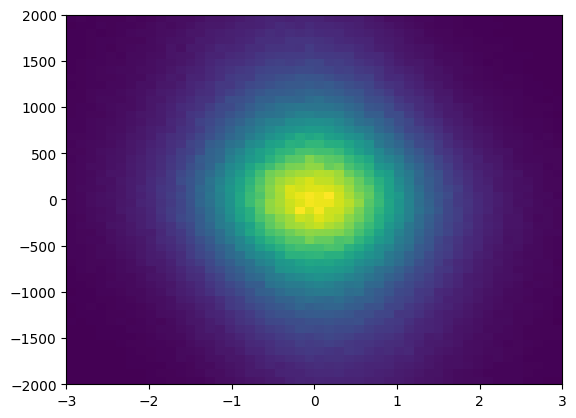

In [89]:
plt.hist2d(higgsCM.eta.to_numpy(),  boost_truth[:,-1].numpy(),
          bins=50, range=((-3,3), (-2000,2000)));

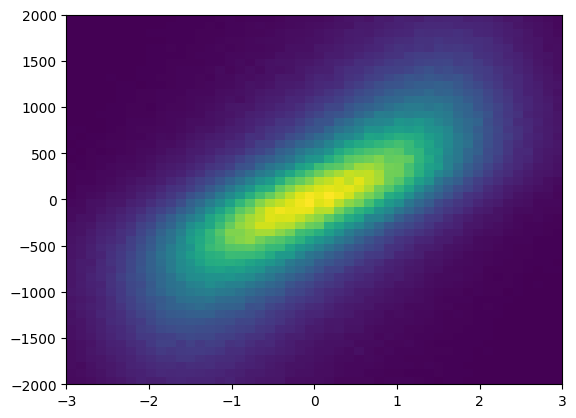

In [23]:
plt.hist2d(higgs_lab[:,0].eta.to_numpy(),  boost_truth[:,-1].numpy(),
          bins=50, range=((-3,3), (-2000,2000)));

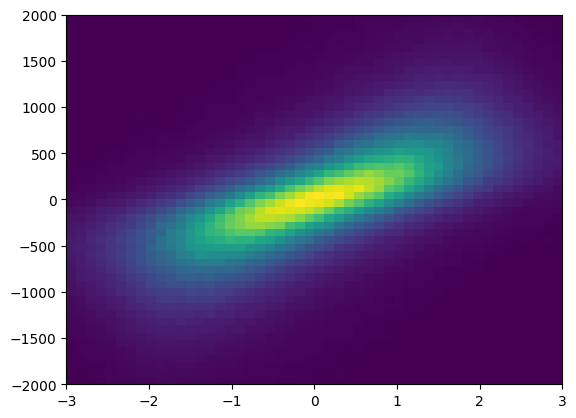

In [24]:
plt.hist2d(higgs_lab[:,0].eta.to_numpy(),  boost_reco[:,-1].numpy(),
          bins=50, range=((-3,3), (-2000,2000)));

Text(0.5, 0, 'Boost pz')

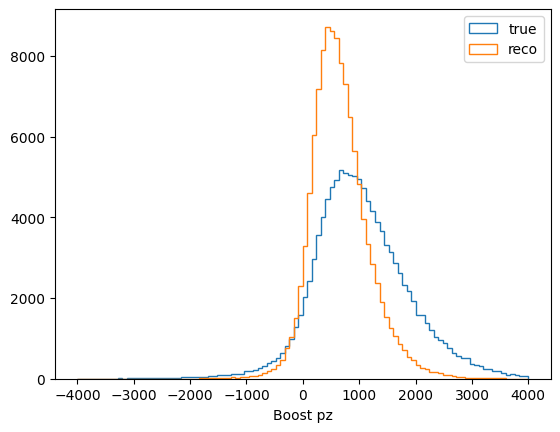

In [46]:
plt.hist(boost_truth[:,3].numpy()[higgs_lab[:,0].eta > 2], bins=100, histtype="step", range=(-4000,4000), label="true");
plt.hist(boost_reco[:,3].numpy()[higgs_lab[:,0].eta > 2], bins=100, histtype="step", range=(-4000,4000), label="reco");
plt.legend()
plt.xlabel("Boost pz")

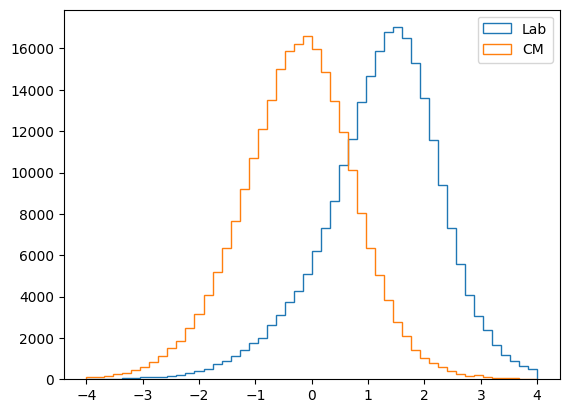

In [31]:
plt.hist(higgs_lab[:,0].eta.to_numpy()[boost_truth[:,-1]>1000],bins=50, range=(-4,4), label="Lab", histtype="step")
plt.hist(higgsCM.eta.to_numpy()[boost_truth[:,-1]>1000],bins=50, range=(-4,4), label="CM", histtype="step")
plt.legend()

In [54]:
higgs_CM_reco_boost = higgs_lab.boost_p4(boost_reco_p4.neg3D)

In [51]:
higgs_CM_true_boost

<MomentumArray4D [[{x: -33.2, y: -51.6, ...}], ...] type='1792125 * var * M...'>

Higgs in the CM from true boost and from reco boost

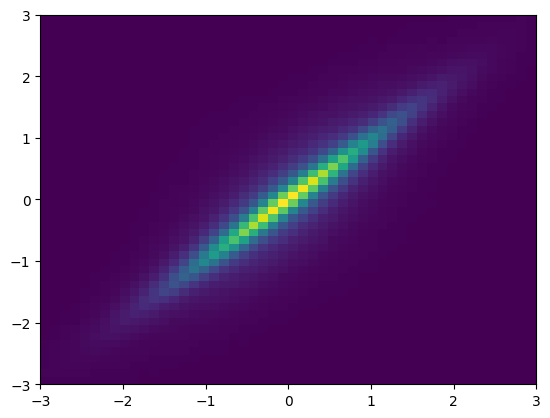

In [79]:
plt.hist2d(higgs_CM_reco_boost[:,0].eta.to_numpy(),  higgsCM.eta.to_numpy(),
          bins=50, range=((-3,3), (-3,3)));

# Taking the problematic region

In [90]:
mask = (higgsCM.eta > 1.5)&(higgsCM.eta<2)

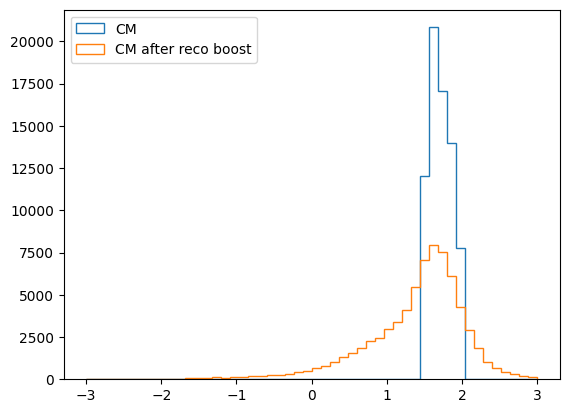

In [91]:
plt.hist(higgsCM.eta[mask], bins=50, range=(-3,3), histtype="step", label="CM");
plt.hist(higgs_CM_reco_boost[:,0].eta[mask], bins=50, range=(-3,3), histtype="step", label="CM after reco boost");
plt.legend()

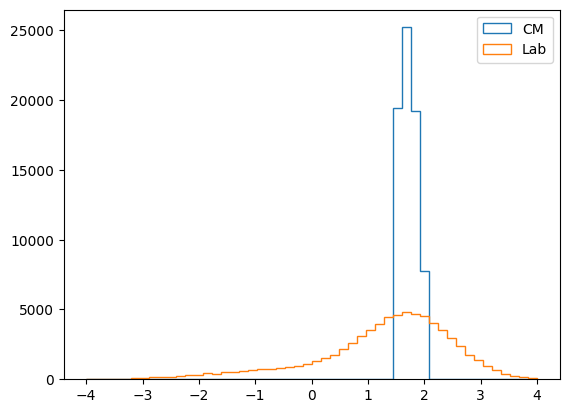

In [94]:
plt.hist(higgsCM.eta[mask], bins=50,range=(-4,4), histtype="step", label="CM");
plt.hist(higgs_lab[:,0].eta[mask], bins=50,range=(-4,4), histtype="step", label="Lab");
plt.legend()

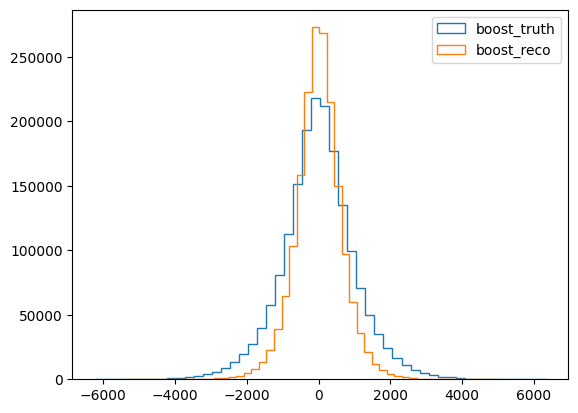

In [72]:
plt.hist(boost_truth[:,-1].numpy(), bins=50, histtype="step", label="boost_truth");
plt.hist(boost_reco[:,-1].numpy(), bins=50, histtype="step", label="boost_reco");
plt.legend()

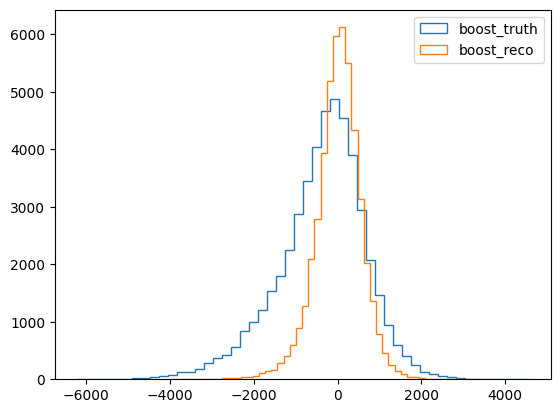

In [67]:
plt.hist(boost_truth[:,-1].numpy()[mask], bins=50, histtype="step", label="boost_truth");
plt.hist(boost_reco[:,-1].numpy()[mask], bins=50, histtype="step", label="boost_reco");
plt.legend()

# Check higgs pt as sum of two jets

In [96]:
data_raw.fields

['partons_matched',
 'partons',
 'generator_info',
 'lepton_partons',
 'lepton_reco',
 'met',
 'higgs',
 'weight',
 'prob_ak',
 'jets']

In [54]:
jets = ak.with_name(data_raw.jets, name="Momentum4D")

In [55]:
higgs_jets = jets[jets.prov==1]
mask = ak.num(higgs_jets)==2
higgs_jets = higgs_jets[mask]

In [56]:
mask_thad = (ak.sum(jets.prov==2, axis=1)==1 ) &( ak.sum(jets.prov==5, axis=1)==2 ) 
jets_prov2 = jets[jets.prov==2][mask_thad]
jets_prov5 = jets[jets.prov==5][mask_thad]

In [57]:
tophad_cand = jets_prov2[:,0]+ jets_prov5[:,0]+jets_prov5[:,1]

In [58]:
Hcand = higgs_jets[:,0] + higgs_jets[:,1]

In [59]:
Hcand_true_lab = higgs_lab[mask]

In [60]:
prov_spanet = data_raw.prob_ak

Text(0.5, 0, 'Higgs eta')

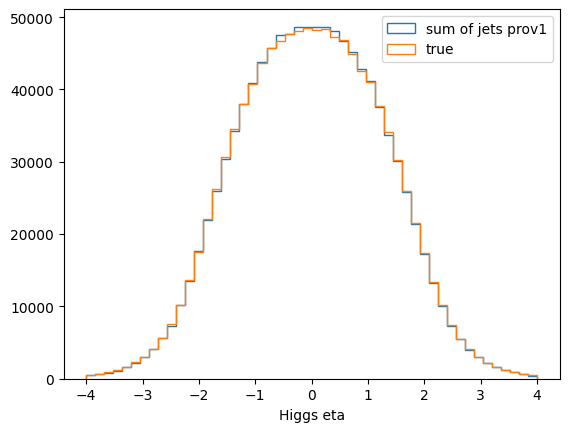

In [61]:
plt.hist(Hcand.eta, bins=50, range=(-4,4), histtype="step", label="sum of jets prov1")
plt.hist(Hcand_true_lab.eta, bins=50, range=(-4,4), histtype="step", label="true");
plt.legend()
plt.xlabel("Higgs eta")

Text(0, 0.5, 'H candidate true lab frame')

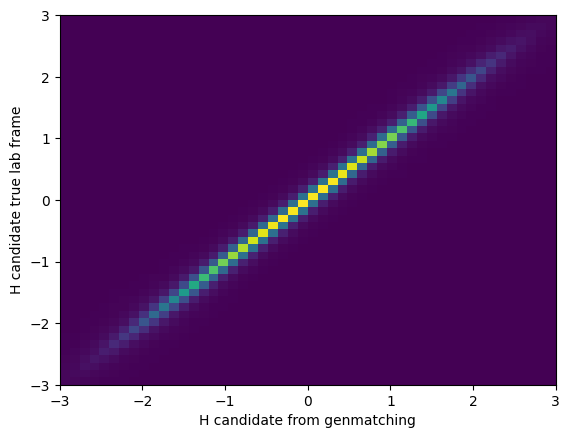

In [62]:
plt.hist2d(Hcand.eta.to_numpy(), 
           Hcand_true_lab[:,0].eta.to_numpy(),
          bins=50, range=((-3,3), (-3,3)));
plt.xlabel("H candidate from genmatching")
plt.ylabel("H candidate true lab frame")

# Evaluating spanet tagging performance

In [63]:
higgs_spanet_jets  = jets[prov_spanet[:,:,2]> 0.]

In [64]:
Hspanet = higgs_spanet_jets[:,0]+ higgs_spanet_jets[:,1]

Hspanet_CM = Hspanet.boost_p4(boost_reco_p4.neg3D)
Hspanet_CM_trueboost =  Hspanet.boost_p4(boost_truth_p4.neg3D)

Text(0, 0.5, 'Higgs spanet inclusive')

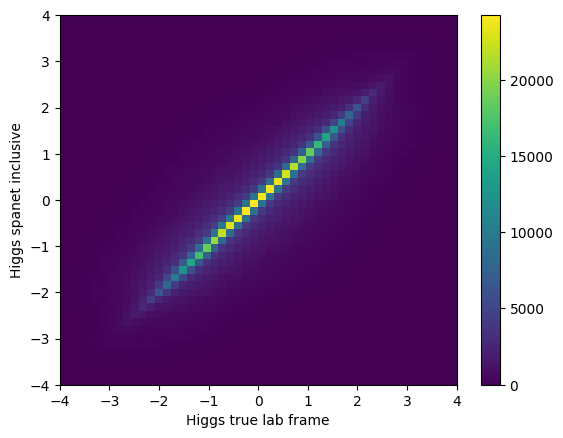

In [66]:
plt.hist2d(
           higgs_lab[:,0].eta.to_numpy(),
           Hspanet.eta.to_numpy(), 
          bins=50, range=((-4,4), (-4,4)));
plt.colorbar()
plt.xlabel("Higgs true lab frame")
plt.ylabel("Higgs spanet inclusive")

Text(0, 0.5, 'Higgs spanet inclusive')

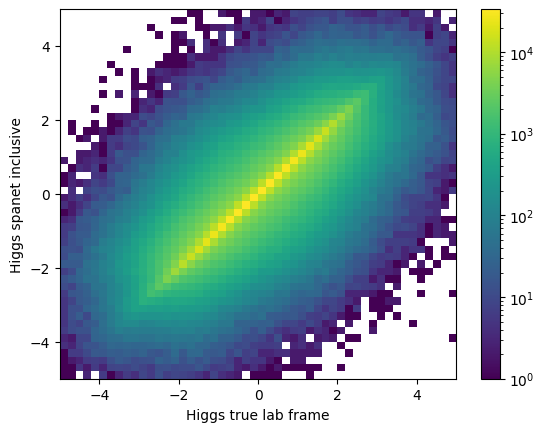

In [67]:
plt.hist2d(
           higgs_lab[:,0].eta.to_numpy(),
           Hspanet.eta.to_numpy(), 
          bins=50, range=((-5,5), (-5,5)), norm=LogNorm());
plt.colorbar()
plt.xlabel("Higgs true lab frame")
plt.ylabel("Higgs spanet inclusive")

Text(0, 0.5, 'Higgs spanet inclusive')

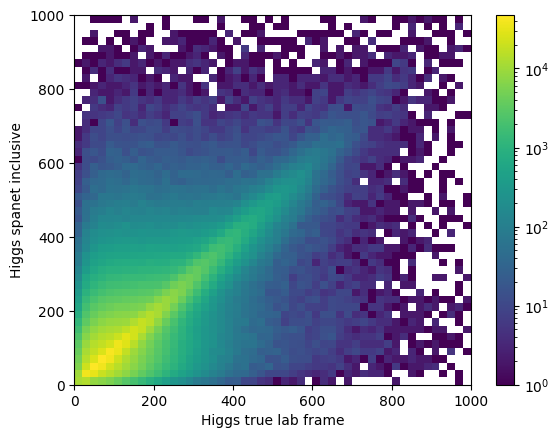

In [76]:
plt.hist2d(
           higgs_lab[:,0].pt.to_numpy(),
           Hspanet.pt.to_numpy(), 
          bins=50, range=((0,1000), (0,1000)), norm=LogNorm());
plt.colorbar()
plt.xlabel("Higgs true lab frame")
plt.ylabel("Higgs spanet inclusive")

Text(0, 0.5, 'Higgs spanet inclusive')

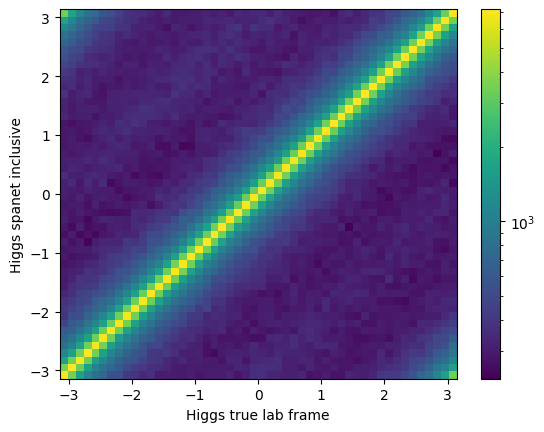

In [77]:
plt.hist2d(
           higgs_lab[:,0].phi.to_numpy(),
           Hspanet.phi.to_numpy(), 
          bins=50, range=((-pi, pi), (-pi,pi)), norm=LogNorm());
plt.colorbar()
plt.xlabel("Higgs true lab frame")
plt.ylabel("Higgs spanet inclusive")

(array([   24.,    21.,    40.,    59.,    51.,    62.,   111.,   129.,
          139.,   206.,   238.,   299.,   357.,   366.,   456.,   513.,
          624.,   718.,   817.,   966.,  1129.,  1298.,  1502.,  1805.,
         2082.,  2531.,  3214.,  4290.,  7544., 18247., 17247.,  6560.,
         3608.,  2718.,  2183.,  1776.,  1500.,  1227.,  1004.,   840.,
          653.,   550.,   463.,   372.,   295.,   239.,   184.,   164.,
          114.,    92.]),
 array([-3.        , -2.88000011, -2.75999999, -2.6400001 , -2.51999998,
        -2.4000001 , -2.27999997, -2.16000009, -2.03999996, -1.91999996,
        -1.79999995, -1.67999995, -1.55999994, -1.44000006, -1.32000005,
        -1.20000005, -1.08000004, -0.95999998, -0.83999997, -0.72000003,
        -0.60000002, -0.47999999, -0.36000001, -0.23999999, -0.12      ,
         0.        ,  0.12      ,  0.23999999,  0.36000001,  0.47999999,
         0.60000002,  0.72000003,  0.83999997,  0.95999998,  1.08000004,
         1.20000005,  1.3200000

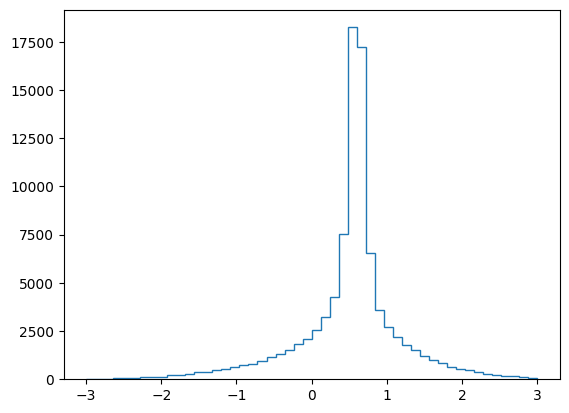

In [288]:
mask = (higgs_lab[:,0].eta>0.5)&(higgs_lab[:,0].eta<0.7)
#plt.hist(higgs_lab[mask,0].eta, bins=50, range=(-3,3), histtype="step")
plt.hist(Hspanet[mask].eta, bins=50,  range=(-3,3), histtype="step")

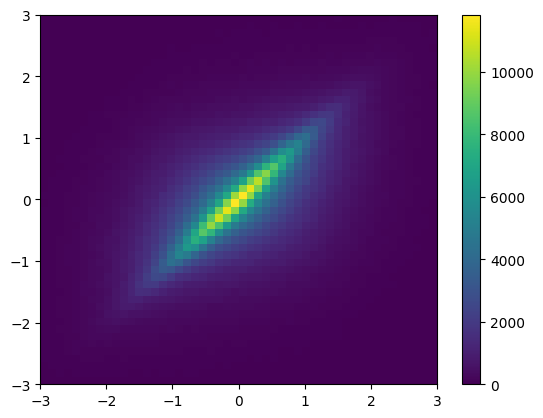

In [70]:
plt.hist2d(
           higgsCM.eta.to_numpy(),
           Hspanet_CM.eta.to_numpy(), 
          bins=50, range=((-3,3), (-3,3)));
plt.colorbar()

In [ ]:
plt.hist2d(
           higgsCM.eta.to_numpy(),
           Hspanet_CM.eta.to_numpy(), 
          bins=50, range=((-3,3), (-3,3)));
plt.colorbar()

Text(0, 0.5, 'H spanet - reco boost')

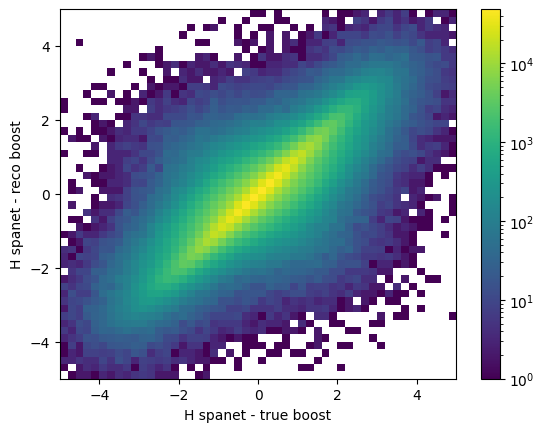

In [71]:
plt.hist2d(
           Hspanet_CM_trueboost.eta.to_numpy(),
           Hspanet_CM.eta.to_numpy(), 
          bins=50, range=((-5,5), (-5,5)), norm=LogNorm());
plt.colorbar()
plt.xlabel("H spanet - true boost")
plt.ylabel("H spanet - reco boost")

Text(0.5, 0, 'Higgs eta')

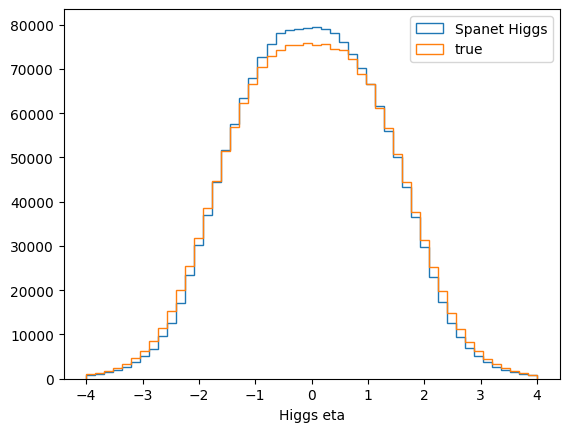

In [72]:
plt.hist(Hspanet.eta, bins=50, range=(-4,4), histtype="step", label="Spanet Higgs")
plt.hist(higgs_lab[:,0].eta, bins=50, range=(-4,4), histtype="step", label="true");
plt.legend()
plt.xlabel("Higgs eta")

Text(0.5, 0, 'Higgs eta')

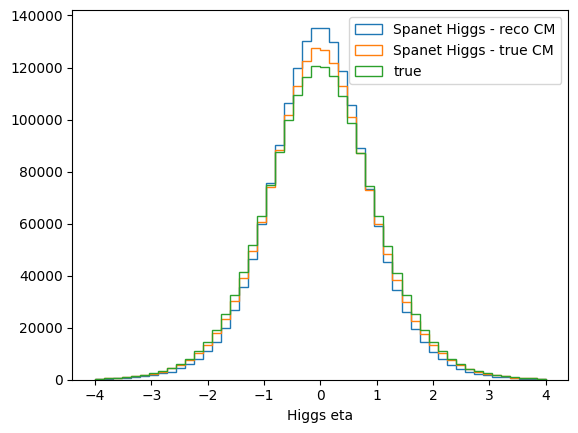

In [73]:
plt.hist(Hspanet_CM.eta, bins=50, range=(-4,4), histtype="step", label="Spanet Higgs - reco CM")
plt.hist(Hspanet_CM_trueboost.eta, bins=50, range=(-4,4), histtype="step", label="Spanet Higgs - true CM")
plt.hist(higgsCM.eta, bins=50, range=(-4,4), histtype="step", label="true");
plt.legend()
plt.xlabel("Higgs eta")

Text(0.5, 0, 'Higgs eta')

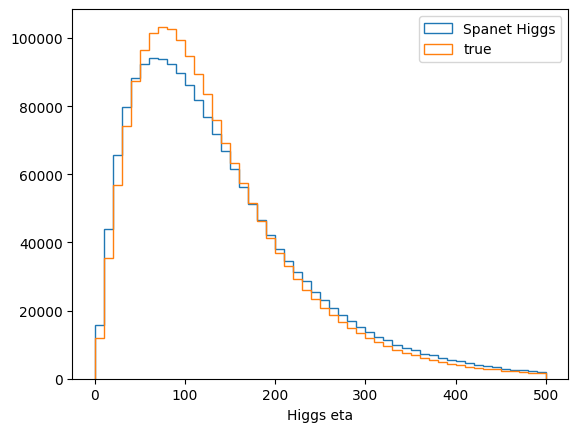

In [196]:
plt.hist(Hspanet.pt, bins=50, range=(0,500), histtype="step", label="Spanet Higgs")
plt.hist(higgs_lab[:,0].pt, bins=50, range=(0,500), histtype="step", label="true");
plt.legend()
plt.xlabel("Higgs eta")

Text(0.5, 0, 'Higgs eta')

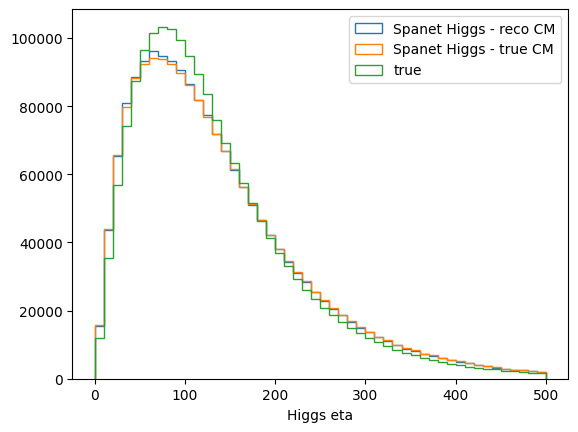

In [271]:
plt.hist(Hspanet_CM.pt, bins=50, range=(0,500), histtype="step", label="Spanet Higgs - reco CM")
plt.hist(Hspanet_CM_trueboost.pt, bins=50, range=(0,500), histtype="step", label="Spanet Higgs - true CM")
plt.hist(higgsCM.pt, bins=50, range=(0,500), histtype="step", label="true");
plt.legend()
plt.xlabel("Higgs eta")

In [200]:
matched_jets_first = (higgs_spanet_jets.prov[:,0] == 1)
matched_jets_second = (higgs_spanet_jets.prov[:,1] == 1)
matched_events = matched_jets_first&matched_jets_second

In [206]:
print(f"Events with first b jets from higgs correct: {100*ak.sum(matched_jets_first)/len(matched_jets_first):.2f}%")
print(f"Events with second b jets from higgs correct: {100*ak.sum(matched_jets_second)/len(matched_jets_second):.2f}%")
print(f"Events with both jets from higgs correct: {100*ak.sum(matched_events)/len(matched_jets_second):.2f}%")

Events with first b jets from higgs correct: 58.54%
Events with second b jets from higgs correct: 55.96%
Events with both jets from higgs correct: 35.17%


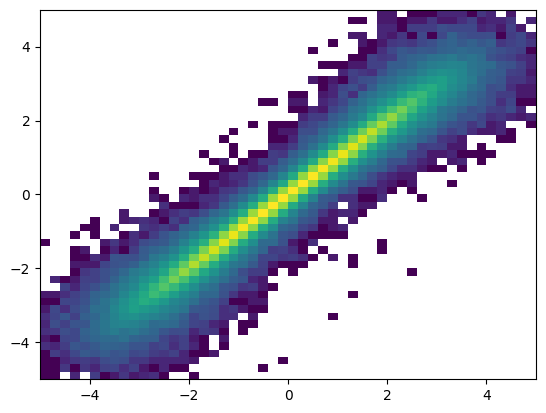

In [215]:
plt.hist2d(
           higgs_lab[matched_events,0].eta.to_numpy(),
           Hspanet[matched_events].eta.to_numpy(), 
          bins=50, range=((-5,5), (-5,5)), norm=LogNorm());

(array([ 213695.,       0.,       0., 2052033.,       0.,  540259.,
         527505.,       0.,   50513.,  200245.]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <BarContainer object of 10 artists>)

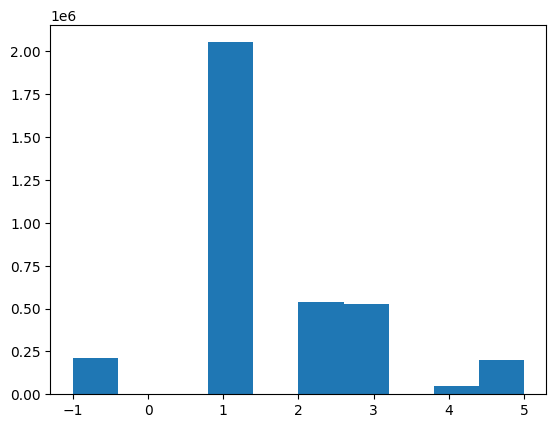

In [199]:
plt.hist(ak.flatten(higgs_spanet_jets.prov))

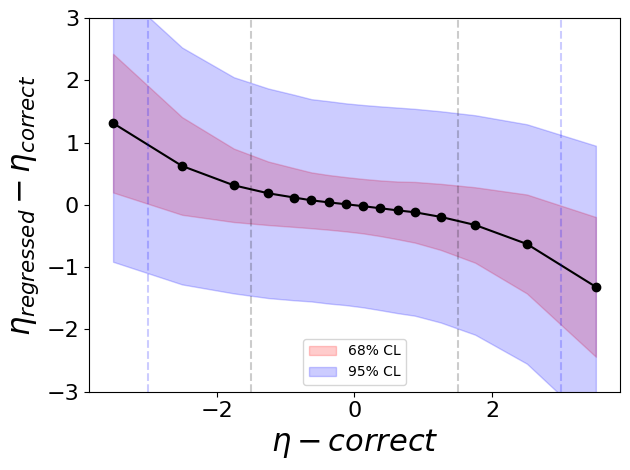

In [216]:
plot_regressionFactor(Hspanet.eta, higgs_lab[:,0].eta,higgs_lab[:,0].eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-3,3], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True)

Text(0.5, 0, 'higgs eta')

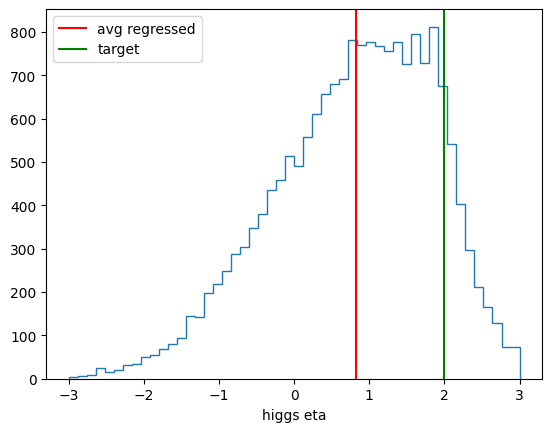

In [278]:
target = 2
mask = ((higgsCM.eta>(target-0.1))&(higgsCM.eta<(target+0.1))).to_numpy()
plt.hist(Hspanet_CM[mask].eta, bins=50, histtype="step", range=(-3,3));
plt.axvline(ak.mean(Hspanet_CM[mask].eta), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
plt.xlabel("higgs eta")
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

Text(0.5, 0, 'higgs eta')

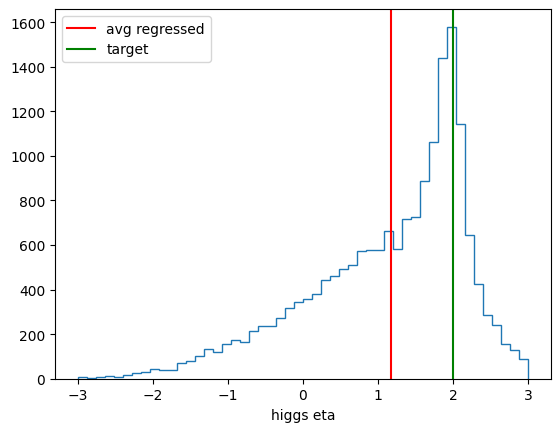

In [279]:
target = 2
mask = ((higgsCM.eta>(target-0.1))&(higgsCM.eta<(target+0.1))).to_numpy()
plt.hist(Hspanet_CM_trueboost[mask].eta, bins=50, histtype="step", range=(-3,3));
plt.axvline(ak.mean(Hspanet_CM_trueboost[mask].eta), c='r', label="avg regressed")
plt.axvline(target, c='g', label="target")
plt.legend()
plt.xlabel("higgs eta")
#plt.axvline( torch.quantile(data_regressed[mask, 0, 1]), c='r')

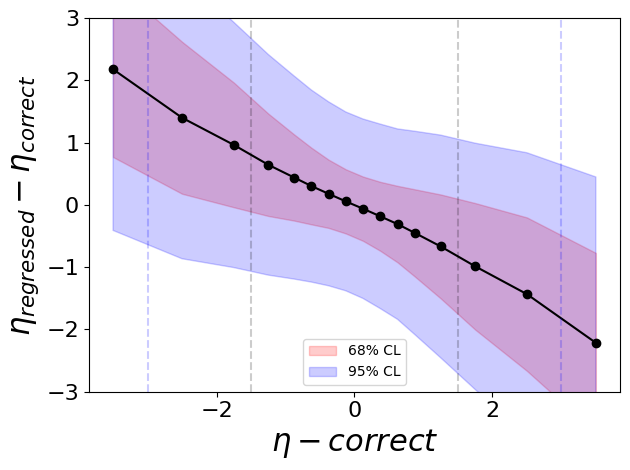

In [246]:
plot_regressionFactor(Hspanet_CM.eta, higgsCM.eta,higgsCM.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-3,3], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True)

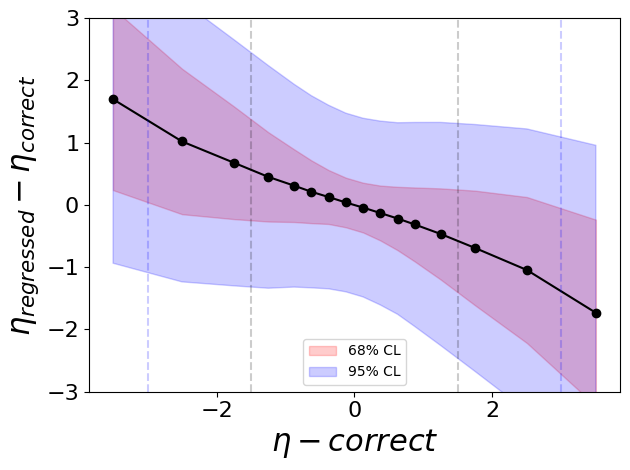

In [274]:
plot_regressionFactor(Hspanet_CM_trueboost.eta, higgsCM.eta,higgsCM.eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-3,3], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True)

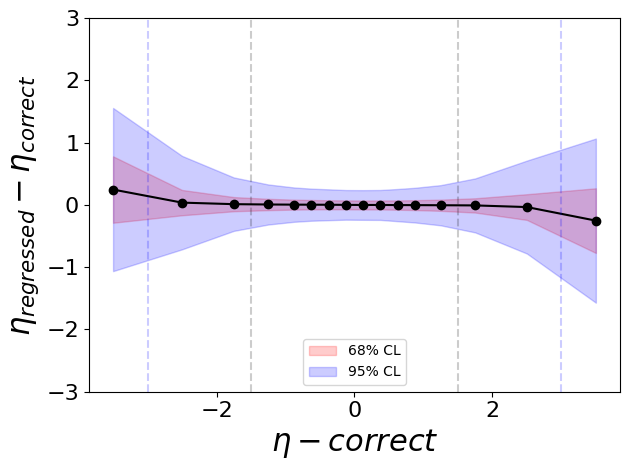

In [218]:
plot_regressionFactor(Hspanet.eta, higgs_lab[:,0].eta,higgs_lab[:,0].eta, matched=matched_events,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-3,3], xname='$\eta-correct$',
                      yname='$\eta_{regressed} - \eta_{correct}$', eta=True)

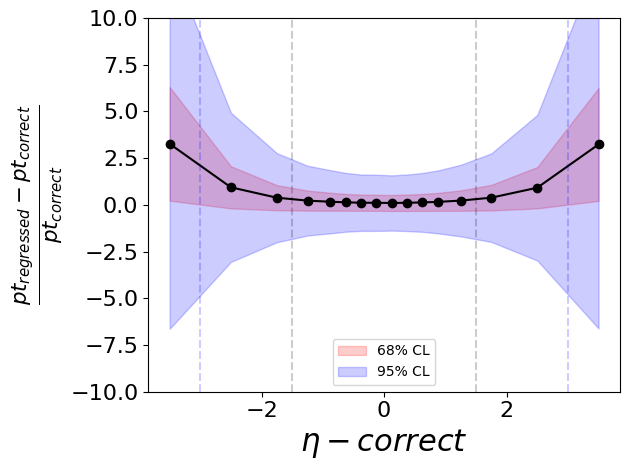

In [222]:
plot_regressionFactor(Hspanet.pt, higgs_lab[:,0].pt, higgs_lab[:,0].eta, matched=None,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     )

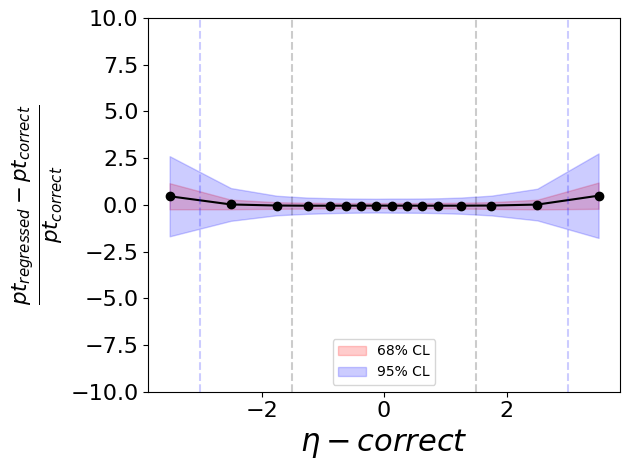

In [235]:
plot_regressionFactor(Hspanet.pt, higgs_lab[:,0].pt, higgs_lab[:,0].eta, matched=matched_events,
                      intervalTargetVar=[-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4],
                      limTarget=(-4, 4), bins=8, ylim=[-10,10], xname='$\eta-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', eta=True, ratio=True,
                     )

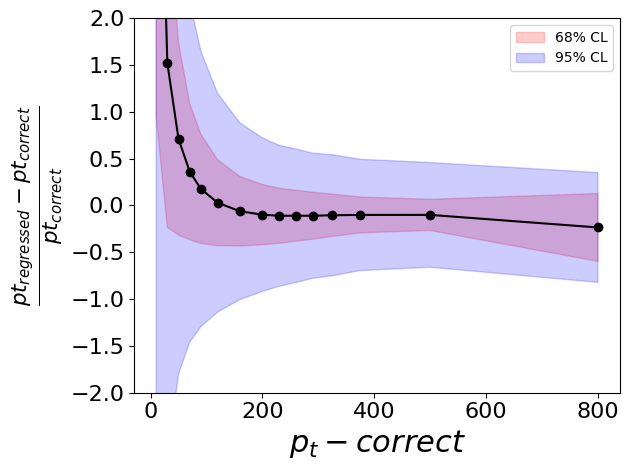

In [233]:
plot_regressionFactor(Hspanet.pt, higgs_lab[:,0].pt, higgs_lab[:,0].pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     )

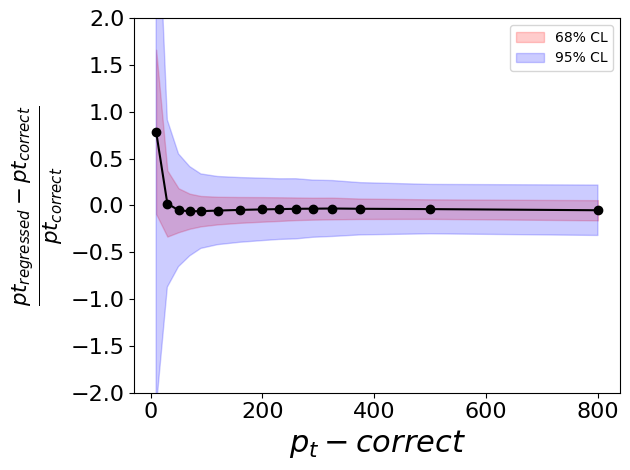

In [234]:
plot_regressionFactor(Hspanet.pt, higgs_lab[:,0].pt, higgs_lab[:,0].pt, matched=matched_events,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     )

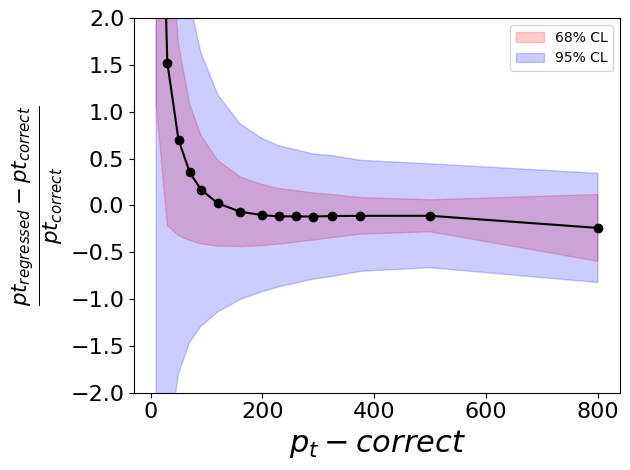

In [247]:
plot_regressionFactor(Hspanet_CM.pt, higgsCM.pt, higgsCM.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     )

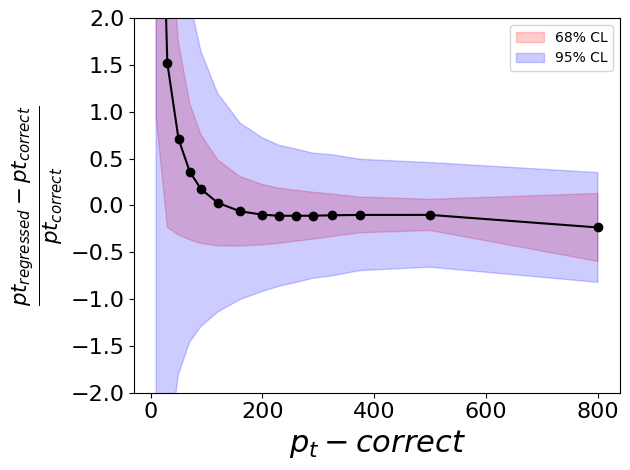

In [275]:
plot_regressionFactor(Hspanet_CM_trueboost.pt, higgsCM.pt, higgsCM.pt, matched=None,
                      intervalTargetVar=[0,20,40,60,80,100,140,180,220,240,280,300,350,400,600,1000],
                      limTarget=(0, 1000), bins=20, ylim=[-2,2], xname='$p_t-correct$',
                      yname=r'$\frac{pt_{regressed} - pt_{correct}}{pt_{correct}}$', ratio=True,
                     )

In [80]:
torch.logit( torch.tensor((1e-5)))

tensor(-11.5129)